In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, PrecisionRecallDisplay, roc_curve, auc
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import SelectFromModel, RFE,RFECV
from sklearn.pipeline import Pipeline
import os
import other_ml_models
from comet_ml import Experiment
from comet_ml.integration.sklearn import log_model
from feature_engineering import FeatureEngineering
from catboost import CatBoostClassifier, Pool, metrics, cv
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
df_train, df_test = FeatureEngineering("data/all_game_data_milesstone_2.csv").train_test_split()

Split into Train and Validation sets

In [4]:
train_cols = ['x_coordinate', 'y_coordinate', 'last_x_coordinate',
       'last_y_coordinate', 'distance_from_last_event', 'last_event',
       'rebound', 'speed', 'time_since_powerplay_started',
       'num_friendly_non_goalie_skaters', 'num_opposing_non_goalie_skaters',
       'is_emptyNet', 'shot_type', 'shot_distance_to_goal',
       'shot_angle', 'change_in_shot_angle']

X = df_train[train_cols]
X.rebound = X.rebound.astype(int)
df_test.rebound = df_test.rebound.astype(int)
y = df_train["is_goal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

/var/folders/47/th8gfrqd2k977395fgq4b6vh0000gn/T/ipykernel_84708/2070492032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rebound = X.rebound.astype(int)


# Ensemble Voting Clf

## Create Pipeline

In [7]:
experiment = Experiment(
  api_key=os.environ.get("COMET_API_KEY"),
  project_name="nhl-data-science",
  workspace="mahmoodhegazy"
)

[experiment.log_dataset_hash(data_set) for data_set in [X_train, X_test, y_train, y_test]]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/mahmoodhegazy/nhl-data-science/78e64bfdfe2542b3972670db94f52bf2



[None, None, None, None]

In [8]:
## Best KNN 
best_knn_params = {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
knn_clf=KNeighborsClassifier(**best_knn_params)
recursive_cv_feature_selection = RFECV( min_features_to_select=1,estimator=LinearRegression())
knn_best_pipe = other_ml_models.create_pipeline(classifier=knn_clf,feature_selection=recursive_cv_feature_selection)

## Best MLP
best_mlp_params = {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50, 100, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
mlp_clf=MLPClassifier(**best_mlp_params, early_stopping=True, n_iter_no_change=10, random_state=42)
feature_selection_svc= SelectFromModel(estimator=LinearSVC(C=0.1, dual="auto"))
mlp_best_pipe = other_ml_models.create_pipeline(classifier=mlp_clf,feature_selection=feature_selection_svc)

## Best RF
best_rf_params = {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
rf_clf= RandomForestClassifier(**best_rf_params, random_state=42)
recursive_cv_feature_selection = RFECV( min_features_to_select=1,estimator=LinearRegression())
rf_best_pipe = other_ml_models.create_pipeline(classifier=rf_clf,feature_selection=recursive_cv_feature_selection)

## Best RF Balanced
best_rf_balanced_params = {'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80}
rf_balanced_clf= RandomForestClassifier(**best_rf_balanced_params, random_state=42)
recursive_cv_feature_selection = RFECV( min_features_to_select=1,estimator=LinearRegression())
rf_balanced_best_pipe = other_ml_models.create_pipeline(classifier=rf_balanced_clf,feature_selection=recursive_cv_feature_selection)

## Best Catboost
best_cat_params = {
    'n_estimators': 500,
    'learning_rate': 0.1,
    'eval_metric': metrics.Accuracy(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}
cat_clf= CatBoostClassifier(**best_cat_params)
recursive_cv_feature_selection = RFECV( min_features_to_select=1,estimator=LinearRegression())
cat_best_pipe = other_ml_models.create_pipeline(classifier=cat_clf,feature_selection=recursive_cv_feature_selection)

In [9]:
vc = VotingClassifier(estimators=[('random_forest',rf_best_pipe),('random_forest_balanced',rf_balanced_best_pipe),('cat_boost_clf',cat_best_pipe),('mlp',mlp_best_pipe), ('KNN', knn_best_pipe)], 
                      voting='soft')
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('Numerical_transform',
                                                                                Pipeline(steps=[('Impt',
                                                                                                 SimpleImputer()),
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x172fd6110>),
                                                                               ('Categorical_transform',
                                                                                Pipeline(steps=[('Impt',
                                                                                                 SimpleImputer(stra...
                                                                                Pipeline(steps=[('Impt',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('encoder',
                                                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                                unknown_value=-1))]),
                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x172fd6810>)])),
                                              ('feature_select',
                                               RFECV(estimator=LinearRegression())),
                                              ('classifier',
                                               KNeighborsClassifier(metric='euclidean',
                                                                    n_neighbors=11))]))],
                 voting='soft')

## Logging Validation Scores

In [10]:
preds = vc.predict(X_test)
preds_train = vc.predict(X_train)

print("Accuracy (train): ", accuracy_score(y_train,preds_train))
print("Accuracy (test): ", accuracy_score(y_test,preds))
print("Classification report:\n", classification_report(y_test,preds))

Accuracy (train):  0.9460998361873258
Accuracy (test):  0.9461685944841245
Classification report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     43126
           1       1.00      0.41      0.58      4337

    accuracy                           0.95     47463
   macro avg       0.97      0.71      0.78     47463
weighted avg       0.95      0.95      0.94     47463



In [12]:
preds_prob = vc.predict_proba(X_test)

{'web': 'https://www.comet.com/api/image/download?imageId=8d58c00f990d42039a2516e37de3d96f&experimentKey=78e64bfdfe2542b3972670db94f52bf2',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=8d58c00f990d42039a2516e37de3d96f&experimentKey=78e64bfdfe2542b3972670db94f52bf2',
 'imageId': '8d58c00f990d42039a2516e37de3d96f'}

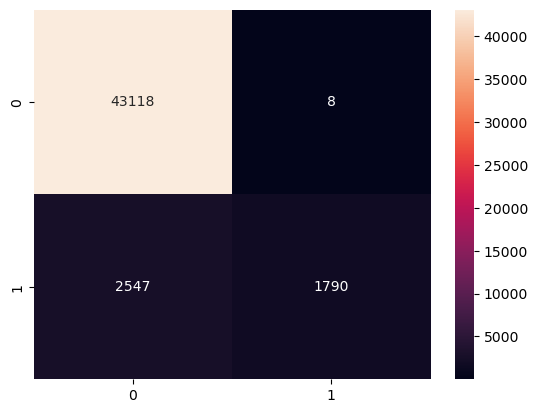

In [13]:
cm=confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True,fmt="d")
experiment.log_figure(figure_name='Confusion Matrix', step=None)

In [14]:
metrics = {"accuracy": accuracy_score(y_test, preds), "f1": f1_score(y_test, preds), "recall": recall_score(y_test, preds), "precision": precision_score(y_test, preds)}
parameter = {
    "model_type": 'Voting Classifier',
    "param_grid": str(vc.get_params()),
}
experiment.log_parameters(parameter)
experiment.log_metrics(metrics)

COMET WARNING: truncated string; too long: '{'estimators': [('random_forest', Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x172fd6110>),
                                                 ('Categorical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                     

### Prec-Recall Curve

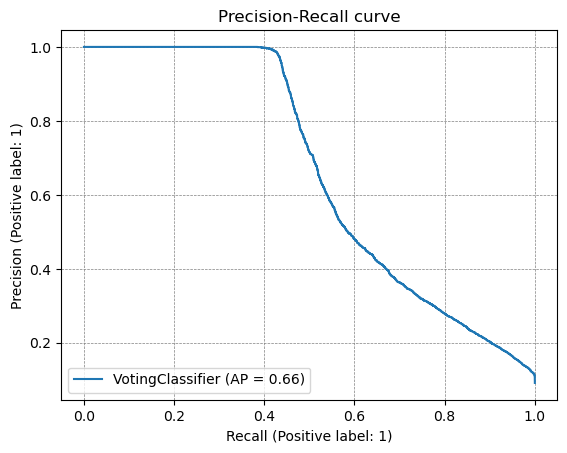

In [15]:
other_ml_models.plot_precision_recall(model=vc, X_test=X_test, y_test=y_test, experiment=experiment)

### ROC Curve

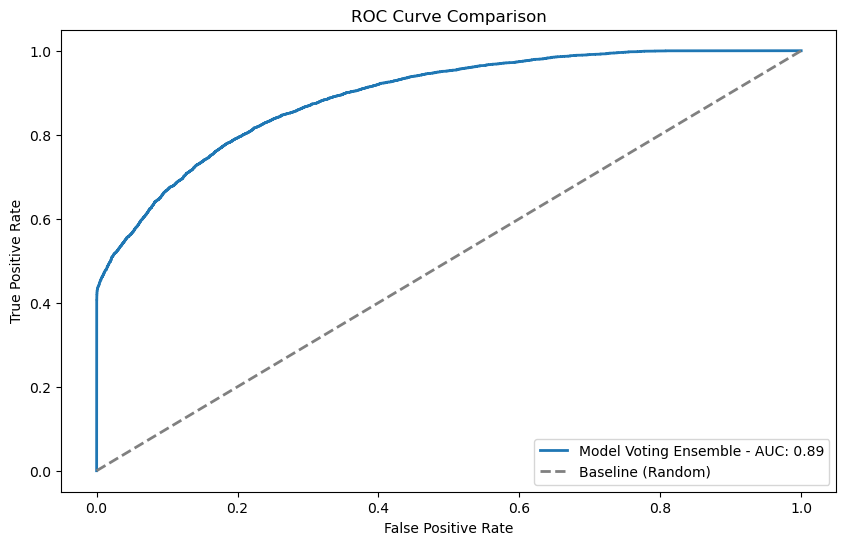

In [16]:
plt.figure(figsize=(10, 6))
line_width = 2

false_positive_rate, true_positive_rate, _ = roc_curve(y_test.ravel(),preds_prob[:,1].ravel())
area_under_curve = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate, lw=line_width, label=f"Model Voting Ensemble - AUC: {area_under_curve:.2f}")

plt.plot([0, 1], [0, 1], color="grey", lw=line_width, linestyle='--', label="Baseline (Random)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
experiment.log_figure(figure_name='ROC-AUC', step=None)
plt.show()

### Goal Rate Plot

In [17]:
bins = list(np.arange(0, 105,  5))
bin_centers = list(np.arange(2.5, 100,  5.0))
df_prob = pd.DataFrame(list(zip(preds ,y_test ,preds_prob[:,1]*100)), columns = ['goal_pred', 'goal','goal_probability'])
df_prob['shot'] = 1
sum_goal = df_prob['goal'].sum()
df_prob['percentile'] = df_prob['goal_probability'].rank(pct=True) * 100
df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels = bin_centers)
df_prob_bined = df_prob[['goal_perc_bins', 'shot', 'goal' ]].groupby(['goal_perc_bins']).sum().reset_index()
df_prob_bined['goal_rate'] = (df_prob_bined['goal']/df_prob_bined['shot'])
df_prob_bined['goal_cum'] = (df_prob_bined['goal']/sum_goal)
df_prob_bined['goal_cumsum'] = 1-df_prob_bined['goal_cum'].cumsum()

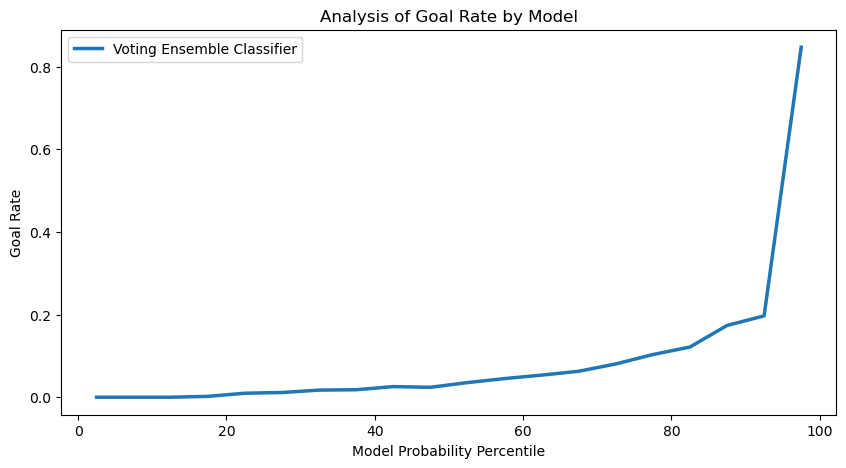

In [18]:
other_ml_models.generate_goal_rate_plot("Voting Ensemble Classifier", df_prob_bined, experiment)

### Cumulative Goal Analysis

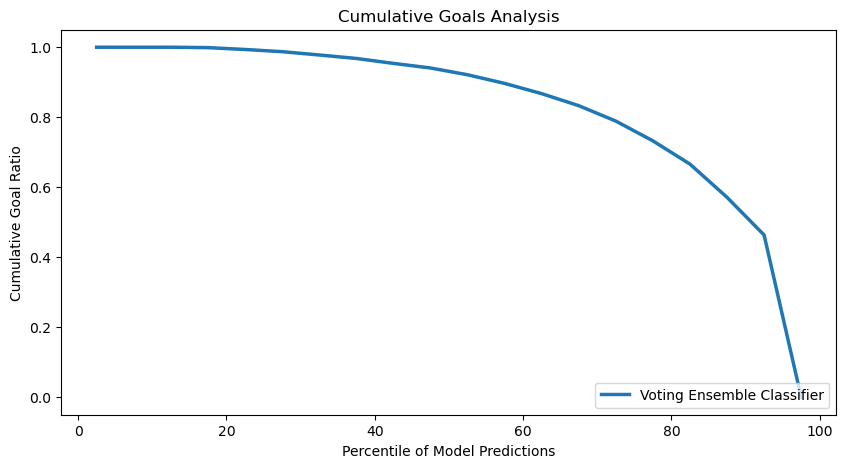

In [19]:
other_ml_models.visualize_cumulative_goals("Voting Ensemble Classifier", df_prob_bined, experiment)

### Calibration curve

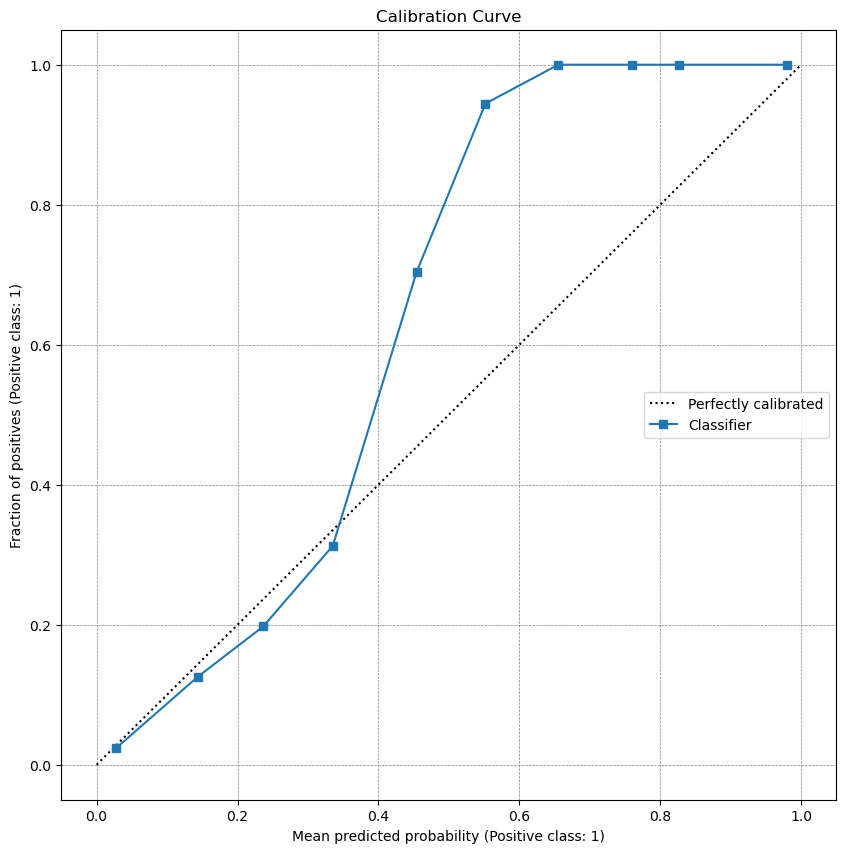

In [20]:
other_ml_models.plot_calibration_curve(y_test, preds_prob, experiment)

### Save Model

In [21]:
import pickle

In [22]:
if not os.path.exists('models/'):
    os.mkdir('models/')
    
pickle.dump(vc, open('models/ensemble.sav', 'wb'))
experiment.log_model("Voting Ensemble Clf", 'models/ensemble.sav')

{'web': 'https://www.comet.com/api/asset/download?assetId=68e8be8b4c374a0cb3d7116d03fb27c5&experimentKey=78e64bfdfe2542b3972670db94f52bf2',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=68e8be8b4c374a0cb3d7116d03fb27c5&experimentKey=78e64bfdfe2542b3972670db94f52bf2',
 'assetId': '68e8be8b4c374a0cb3d7116d03fb27c5'}

In [23]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mahmoodhegazy/nhl-data-science/78e64bfdfe2542b3972670db94f52bf2
COMET INFO:   Metrics:
COMET INFO:     accuracy  : 0.9461685944841245
COMET INFO:     f1        : 0.5835370823145885
COMET INFO:     precision : 0.9955506117908788
COMET INFO:     recall    : 0.4127276919529629
COMET INFO:   Parameters:
COMET INFO:     model_type : Voting Classifier
COMET INFO:     param_grid : {'estimators': [('random_forest', Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical_transform',
                                                  Pipeline(steps=[('Impt',
                                            